In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

In [5]:
data = pd.read_csv('data/train.csv')

# Import and separate input vs target

In [4]:
# Identify the input columns (a list of column names - not including ID or Sale Price)
input_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']
# Identify the name of the target column (a single string, not a list)
target_col = 'SalePrice'

In [6]:
#make a copy of input - keep your notebook clean
inputs = data[input_cols].copy()
targets = data[target_col]

In [9]:
categorical_cols = [var for var in data.columns if data[var].dtype == 'O']
numerical_cols = [var for var in data.columns if var not in categorical_cols and var != 'SalePrice']

vars_missing = [var for var in data.columns if data[var].isnull().sum() > 0]

categorical_na = [var for var in categorical_cols if var in vars_missing]
numerical_na = [var for var in numerical_cols if var in vars_missing]

print('Number of categorical variables with NA: ', len(categorical_na))
print('Number of numerical variables with NA: ', len(numerical_na))

Number of categorical variables with NA:  16
Number of numerical variables with NA:  3


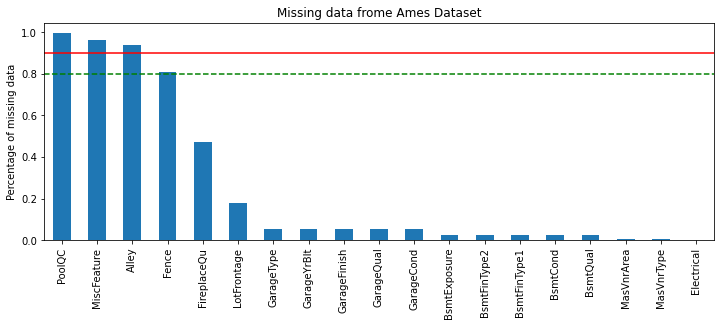

In [10]:
data[vars_missing].isnull().mean().sort_values(ascending = False).plot.bar(figsize = (12,4))
plt.ylabel('Percentage of missing data')
plt.title('Missing data frome Ames Dataset')
plt.axhline(0.9, color = 'red', linestyle = '-')
plt.axhline(0.8, color = 'green', linestyle = '--')

# Drop the first 4 -over 80% null